## Decision making example - gradient boosting and a collection of interpretation metrics

In [41]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

In this example, we will train an Xgboost-model to a collection of financial figures from S&P1500 companies. Then, we will use a set of interpretation metrics to analyse our results.

Let's start by loading our data. For that, we need the pandas library that has a convenient function to read csv-files.

In [2]:
import pandas as pd

**index_col=0** defines the location of an index column. This csv-file is not available anywhere. If you want to repeat the analysis, create a csv-file that has companies as rows and different financial figures as columns.

In [3]:
master_df = pd.read_csv('FINAL_FIGURES_PANEL.csv',index_col=0)

Our example data is not the best one. It has many missing values and even some inf-values. To make further analysis easier, I set pandas to consider inf-values as nan-values.

In [4]:
pd.options.mode.use_inf_as_na = True

We build a model where we try to predict Tobin's Q using other financial figures from companies. Therefore we should remove those instances that do not have a Tobin's Q value. With **loc** we can locate instances, in this case, those instances that have a missing value (**isna()** tells that) in the Tobin's Q variable.
Because we removed some instances, the index is now all messed up. With **reset_index()** we can set it back to a sequential row of numbers.

In [5]:
master_df = master_df.loc[~master_df['TobinQ'].isna()]
master_df.reset_index(inplace=True,drop=True)

Below, we apply winsorisation to the data. An explanation from Wikipedia: "Winsorisation is the transformation of statistics to set all outliers to a specified percentile of the data; for example, a 90% winsorisation would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile.

In [6]:
master_df['TobinQ'].clip(lower=master_df['TobinQ'].quantile(0.05), upper=master_df['TobinQ'].quantile(0.95),inplace = True)

With pandas, we can quickly draw a histogram of a variable. Here is Tobin's Q. The higher frequency of values around twelve is caused by winsorisation.

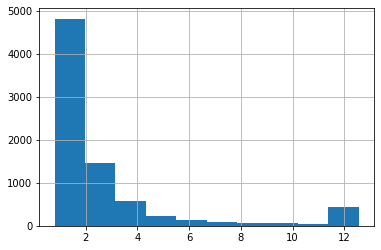

In [7]:
master_df['TobinQ'].hist()

Our dataframe has many variables. However, there are very similar variables, and we use only part of them to get meaningful results.

In [8]:
master_df.columns

Index(['CIK', 'Name', 'Year', 'TOTAL ASSETS (U.S.$)', 'COMMON EQUITY (U.S.$)',
       'MARKET CAPITALIZATION (U.S.$)', 'NET SALES OR REVENUES (U.S.$)',
       'NET INCOME (U.S.$)', 'EARNINGS PER SHARE',
       'EARNINGS BEF INTEREST & TAXES', 'DIVIDEND YIELD - CLOSE',
       'NET SALES/REVENUES -1YR ANN GR', 'NET INCOME - 1 YR ANNUAL GROWT',
       'RETURN ON EQUITY - TOTAL (%)', 'RETURN ON ASSETS',
       'RETURN ON INVESTED CAPITAL', 'SELLING, GENERAL & ADM / SALES',
       'RESEARCH & DEVELOPMENT/SALES', 'OPERATING PROFIT MARGIN',
       'TOTAL DEBT % TOTAL CAPITAL/STD', 'QUICK RATIO', 'CURRENT RATIO',
       'BRANDS, PATENTS - NET', 'BRANDS, PATENTS - ACCUM AMORT',
       'BRANDS, PATENTS - GROSS', 'EMPLOYEES',
       'EMPLOYEES - 1 YR ANNUAL GROWTH', 'SALES PER EMPLOYEE',
       'ASSETS PER EMPLOYEE', 'CURRENT LIABILITIES-TOTAL', 'TOTAL LIABILITIES',
       'TOTAL INVESTMENT RETURN', 'PRICE/BOOK VALUE RATIO - CLOSE',
       'PRICE VOLATILITY', 'FOREIGN ASSETS % TOTAL ASSETS',
    

As predictors, we pick the following variables. There are still highly correlated variables. One good aspect of tree-based boosting methods is that multicollinearity is much less of an issue.

In [9]:
features = ['Year', 'DIVIDEND YIELD - CLOSE',
       'NET SALES/REVENUES -1YR ANN GR', 'NET INCOME - 1 YR ANNUAL GROWT',
       'RETURN ON EQUITY - TOTAL (%)', 'RETURN ON ASSETS',
       'RETURN ON INVESTED CAPITAL', 'SELLING, GENERAL & ADM / SALES',
       'RESEARCH & DEVELOPMENT/SALES', 'OPERATING PROFIT MARGIN',
       'TOTAL DEBT % TOTAL CAPITAL/STD', 'QUICK RATIO', 'CURRENT RATIO',
       'TOTAL INVESTMENT RETURN',
       'PRICE VOLATILITY', 'FOREIGN ASSETS % TOTAL ASSETS',
       'FOREIGN SALES % TOTAL SALES', 'FOREIGN INCOME % TOTAL INCOME',
       'FOREIGN RETURN ON ASSETS', 'FOREIGN INCOME MARGIN',
       'ACCOUNTS PAYABLE/SALES', 'CASH FLOW/SALES', 'COST OF GOODS SOLD/SALES']

We temporarily move the predictor variables to another dataframe for winsorisation.

In [10]:
features_df = master_df[features]

In [11]:
features_df.clip(lower=features_df.quantile(0.05), upper=features_df.quantile(0.95), axis = 1,inplace = True)

We move back the winsorised predictor variables to master_df.

In [12]:
master_df[features] = features_df

With the pandas function **describe()**, we can easily calculate basic statistics for the features.

In [13]:
master_df[features].describe().transpose()

count         mean         std        min  \
Year                            7921.0  2005.090393    7.337131  1994.0000   
DIVIDEND YIELD - CLOSE          7893.0     0.486829    0.910837     0.0000   
NET SALES/REVENUES -1YR ANN GR  7579.0    11.159821   30.259285   -38.0540   
NET INCOME - 1 YR ANNUAL GROWT  3815.0    45.183943  112.854050   -75.5250   
RETURN ON EQUITY - TOTAL (%)    6862.0    -4.885381   38.409156  -123.8240   
RETURN ON ASSETS                7687.0    -9.839917   37.518729  -140.5340   
RETURN ON INVESTED CAPITAL      7305.0    -6.064327   34.695127  -116.9260   
SELLING, GENERAL & ADM / SALES  7640.0    36.152825   41.764955     8.5995   
RESEARCH & DEVELOPMENT/SALES    6635.0    10.029486   11.853524     0.0000   
OPERATING PROFIT MARGIN         7694.0   -14.559555   61.399007  -243.9660   
TOTAL DEBT % TOTAL CAPITAL/STD  7793.0    25.006322   25.731029     0.0000   
QUICK RATIO                     7863.0     1.782639    1.444924     0.2100   
CURRENT RATIO                   7894.0     2.607263    1.719357     0.3800   
TOTAL INVESTMENT RETURN         7601.0    11.283903   56.890718   -73.2100   
PRICE VOLATILITY                6706.0    40.259398   15.117033    19.5625   
FOREIGN ASSETS % TOTAL ASSETS   6078.0    11.155938   14.960890     0.0000   
FOREIGN SALES % TOTAL SALES     6762.0    32.920694   25.527471     0.0000   
FOREIGN INCOME % TOTAL INCOME   5593.0    19.151371   32.119147   -18.9100   
FOREIGN RETURN ON ASSETS        3705.0    35.858306   77.912989   -47.2420   
FOREIGN INCOME MARGIN           3977.0     5.135768    8.061430   -10.5760   
ACCOUNTS PAYABLE/SALES          7676.0    10.580265    8.139577     3.1700   
CASH FLOW/SALES                 7702.0    -6.902811   45.553832  -176.3760   
COST OF GOODS SOLD/SALES        7672.0    60.270517   16.469725    23.0600   

                                      25%        50%         75%         max  
Year                            1999.0000  2005.0000  2011.00000  2018.00000  
DIVIDEND YIELD - CLOSE             0.0000     0.0000     0.58000     2.96000  
NET SALES/REVENUES -1YR ANN GR    -5.7000     6.4700    22.32500    91.86900  
NET INCOME - 1 YR ANNUAL GROWT   -18.8100    15.1100    62.18500   406.44900  
RETURN ON EQUITY - TOTAL (%)      -9.7600     7.0200    16.31750    37.71850  
RETURN ON ASSETS                  -9.0950     3.9300     8.73000    18.58700  
RETURN ON INVESTED CAPITAL        -8.8900     5.8600    12.79000    27.58000  
SELLING, GENERAL & ADM / SALES    15.5675    22.2400    33.48500   185.97300  
RESEARCH & DEVELOPMENT/SALES       1.9100     5.3800    13.65500    46.55100  
OPERATING PROFIT MARGIN           -5.0300     5.6200    11.09750    21.11800  
TOTAL DEBT % TOTAL CAPITAL/STD     0.2700    18.7800    40.74000    85.84800  
QUICK RATIO                        0.8500     1.2900     2.20000     5.85000  
CURRENT RATIO                      1.4600     2.1400     3.24000     7.14700  
TOTAL INVESTMENT RETURN          -28.4400     3.7400    39.06000   151.91000  
PRICE VOLATILITY                  27.2300    38.3300    50.27750    71.87250  
FOREIGN ASSETS % TOTAL ASSETS      0.0000     4.2800    16.06000    50.85600  
FOREIGN SALES % TOTAL SALES        7.2425    33.2500    52.00000    81.54850  
FOREIGN INCOME % TOTAL INCOME      0.0000     0.0000    32.89000   104.02600  
FOREIGN RETURN ON ASSETS           0.0000     8.0300    32.59000   298.70400  
FOREIGN INCOME MARGIN              0.0000     3.7700     9.97000    23.01800  
ACCOUNTS PAYABLE/SALES             5.7580     8.0695    11.80325    37.66225  
CASH FLOW/SALES                   -0.4175     7.4300    12.15000    22.85950  
COST OF GOODS SOLD/SALES          50.3575    62.9800    72.51000    85.28350

Tobin's Q to the **y_df** dataframe.

In [14]:
y_df = master_df['TobinQ']

The features to the **x_df** dataframe.

In [15]:
x_df = master_df[features]

### Gradient boosting
**Xgboost** is implemented as a Python library, which we import here and name it **xgb**.

In [16]:
import xgboost as xgb

Xgboost uses its' own data structure, called DMatrix. It speeds up calculations significantly and saves memory. We feed the data as pandas dataframes. The data can also be numpy arrays. **nthread = -1** tells Xgboost to use all the cores available for calculations.

In [17]:
dtrain = xgb.DMatrix(x_df, label=y_df, nthread = -1)

Next, we need to define the parameters of the xgboost model. This is a very difficult task and more like black magic than science. You can easily play with different hyperparameter settings for days, and still finding combinations that improve the performance. And here is only part of the parameters! More info about the parameters is here: [xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [18]:
m_depth = 5
eta = 0.1
ssample = 0.8
col_tree = 0.8
m_child_w = 3
gam = 1.
objective = 'reg:squarederror'
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample,
         'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam,'objective' : objective}

Xgboost has a function for cross-validation. We use here 5 folds. The metric is **mean absolute error**.
![validation](./images/Train-Test-Validation.png)

In [19]:
temp = xgb.cv(param,dtrain,num_boost_round=1500,nfold=5,seed=10,metrics='mae')

To plot how our *mae* is decreasing, we load Matplotlib.

In [20]:
import matplotlib.pyplot as plt

There are indications for overfitting, but let's proceed. Around 800 rounds (decision trees), the validation error is minimum, so let's use that.

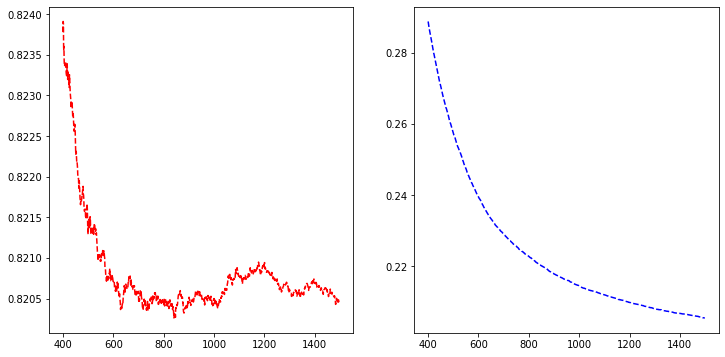

In [21]:
fig, axs = plt.subplots(1,2,figsize=(12,6),squeeze=True)
axs[0].plot(temp['test-mae-mean'][400:1500],'r--')
axs[1].plot(temp['train-mae-mean'][400:1500],'b--')

In [22]:
b_rounds = 800

**train()** is used for training. We feed the parameters, the data in a DMAtrix format and the number of boosting rounds to the function.

In [23]:
bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

### SHAP

Now we have our model trained, and we can start analysing it. Let's start with SHAP [github.com/slundberg/shap](https://github.com/slundberg/shap)

In [24]:
import shap

In [25]:
j=0
shap.initjs()

We define a SHAP tree-explainer and use the data to calculate the SHAP values.

In [26]:
explainerXGB = shap.TreeExplainer(bst)
shap_values_XGB_test = explainerXGB.shap_values(x_df,y_df)

SHAP has many convenient functions for model analysis.

Summary_plot with **plot_type = 'bar'** for a quick feature importance analysis. However, for global importance analysis, you should use SAGE instead, because SHAP is prone to errors with the least important features.

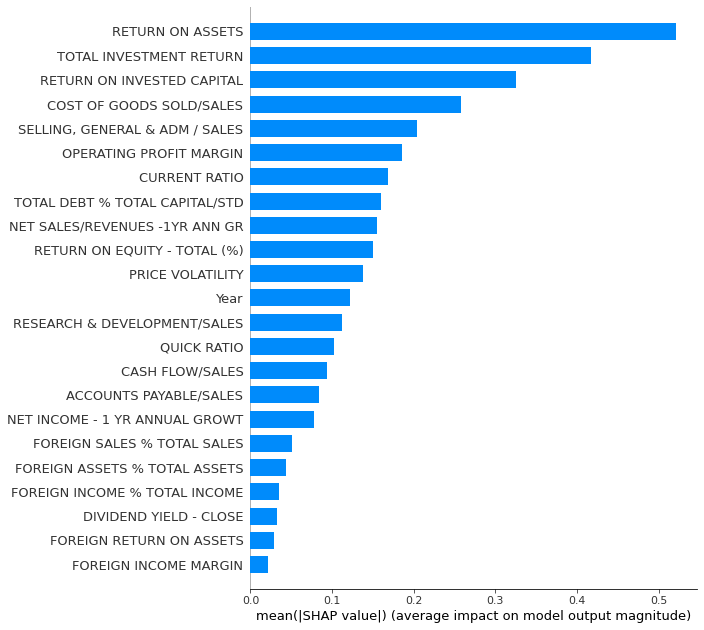

In [27]:
shap.summary_plot(shap_values_XGB_test,x_df,plot_type='bar',max_display=30)

With **plot_type = 'dot'** we get a much more detailed plot.

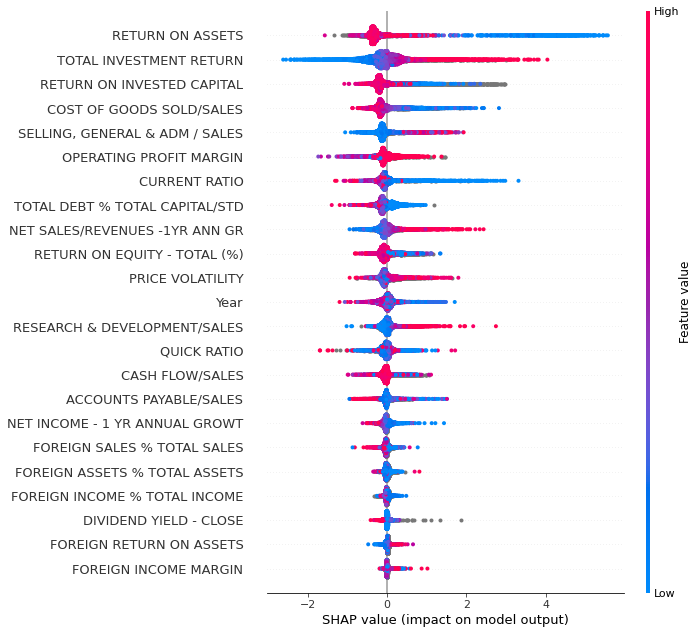

In [28]:
shap.summary_plot(shap_values_XGB_test,x_df,plot_type='dot',max_display=30)

Next, we use the SHAP values to build up 2D scatter graphs for every feature. They shows the effect of a feature for the prediction for every instance.

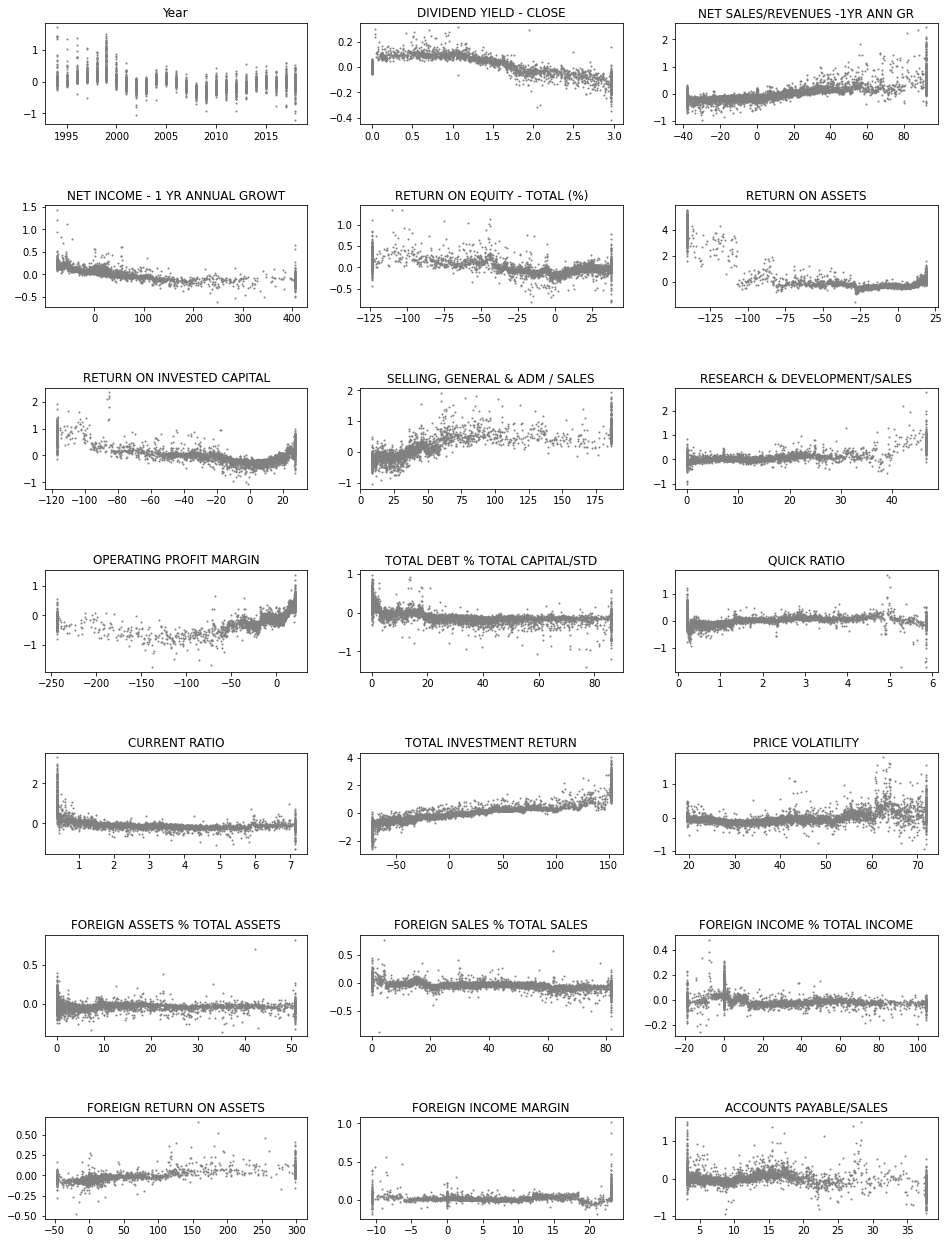

In [29]:
fig, axs = plt.subplots(7,3,figsize=(16,22),squeeze=True)
ind = 0
for ax in axs.flat:
    feat = bst.feature_names[ind]
    ax.scatter(x_df[feat],shap_values_XGB_test[:,ind],s=1,color='gray')
#    ax.set_ylim([-0.2,0.2])
    ax.set_title(feat)
    ind+=1
plt.subplots_adjust(hspace=0.8)
plt.savefig('shap_sc.png')

**Decision_plot()** is interesting as it shows how the prediction is formed from the contributions of different features.

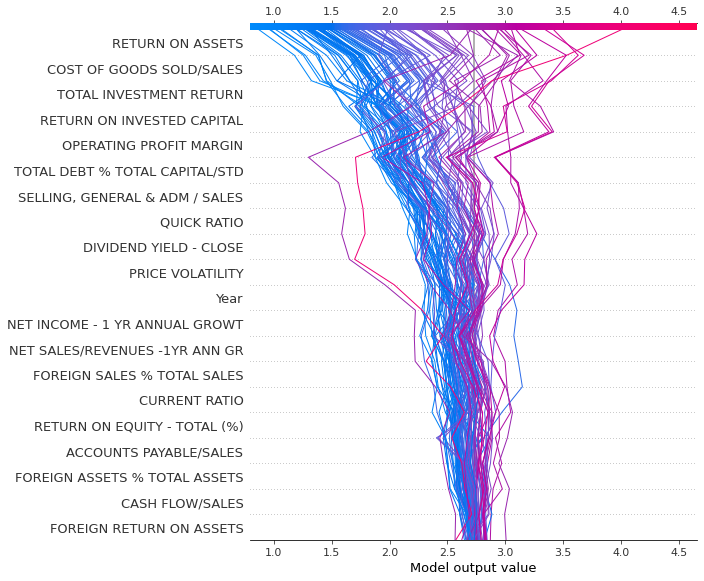

In [30]:
shap.decision_plot(explainerXGB.expected_value,shap_values_XGB_test[0:100],features)

**Force_plot** is similar to decision_plot. We plot only the first 100 instances because it would be very slow to draw a force_plot with all the instances.

In [31]:
shap.force_plot(explainerXGB.expected_value,shap_values_XGB_test[0:100],features,figsize=(20,10))

**Waterfall_plot** is great when you want to analyse one instance.

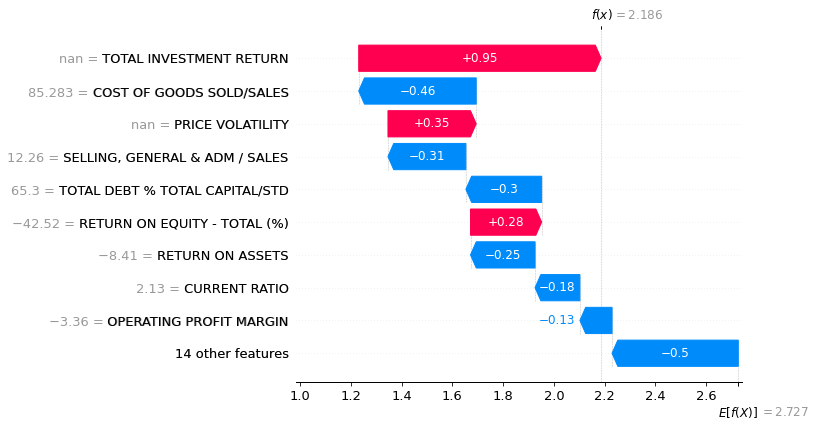

In [32]:
shap.waterfall_plot(explainerXGB.expected_value,shap_values_XGB_test[2000],x_df.iloc[2000],features)

### Other interpretation methods

For the following methods, we need to use the Xgboost's Scikit-learn wrapper **XGBRegressor()** to make our Xgboost model to be compatible with the Scikit-learn ecosystem.

In [33]:
m_depth = 5
eta = 0.1
ssample = 0.8
col_tree = 0.8
m_child_w = 3
gam = 1.
objective = 'reg:squarederror'
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample,
         'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam,'objective' : objective}

Our xgboost model as a Scikit-learn model.

In [34]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree=col_tree, gamma=gam,
                                  learning_rate=eta, max_depth=m_depth,
                                  min_child_weight=m_child_w, n_estimators=800, subsample=ssample)

**fit()** is used to train a model in Scikit.

In [35]:
best_xgb_model.fit(x_df,y_df)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

**pdpbox** library has a function for partial dependence plot and individual conditional expectations: [github.com/SauceCat/PDPbox](https://github.com/SauceCat/PDPbox)

In [36]:
from pdpbox import pdp

Here is a code to draw a partial dependence plot and individual conditional expectations. **features[5]** is the feature Return on Assets. These methods do not like missing values in features, so we fill missing values with zeroes. Not a theoretically valid approach, but...

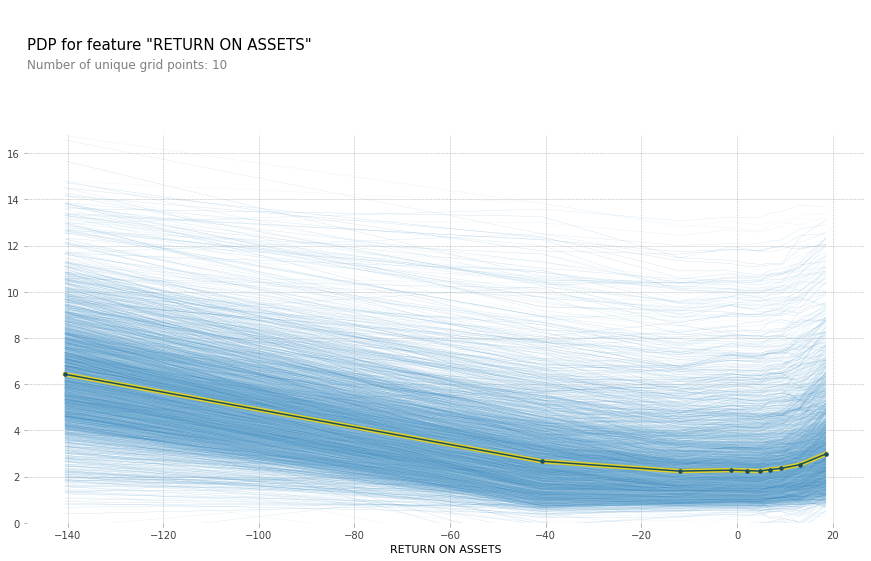

In [37]:
plt.rcParams["figure.figsize"] = (20,20)
pdp_prep = pdp.pdp_isolate(best_xgb_model,x_df.fillna(0),features,features[5])
fig, axes = pdp.pdp_plot(pdp_prep, features[5],center=False, plot_lines=True,frac_to_plot=0.5)
plt.savefig('ICE.png')

ALEPython has functions for ALE plots: [github.com/blent-ai/ALEPython](https://github.com/blent-ai/ALEPython)

In [38]:
import ale

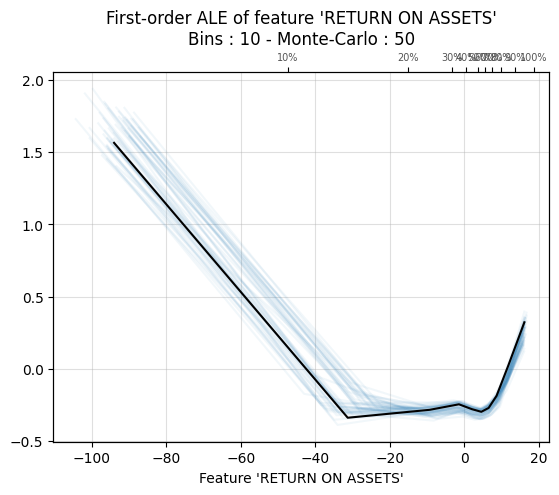

<Figure size 640x480 with 0 Axes>

In [40]:
plt.rcdefaults()
ale.ale_plot(best_xgb_model,x_df.fillna(0),features[5],monte_carlo=True)
plt.savefig('ale.png')